In [16]:
from IPython.display import Audio
import librosa

import tensorflow.compat.v1 as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import torchaudio, torch

### Load the dataset

In [17]:
## Building the data tensor set
## Using 3400 audios for each classes
## for counting number of data in the dataset through file system;
## Reference method: image_count = len(list(DATASETPATH.glob('./*.wav')))
data_tensor_yes = []
data_tensor_no = []
data_tensor_test_yes = []
data_tensor_test_no = []
for i in range(3400):
    filename = './Dataset/yes/yes' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_yes.append(np.array(data_audio_tensor[0].tolist()))
for i in range(3400):
    filename = './Dataset/no/no' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_no.append(np.array(data_audio_tensor[0].tolist()))
## load test dataset
for i in range(490):
    filename = './test_set/yes/yes' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_test_yes.append(np.array(data_audio_tensor[0].tolist()))
for i in range(490):
    filename = './test_set/no/no' + str(i+1) + '.wav'
    data_audio_tensor, data_rate = torchaudio.load(filename)
    data_tensor_test_no.append(np.array(data_audio_tensor[0].tolist()))
print(len(data_tensor_yes[0]))

16000


In [24]:
## Construct the mfcc set
mfcc_set_yes = []
mfcc_set_no = []

mfcc_test_set_yes = []
mfcc_test_set_no = []

mfcc_train_labels = []
mfcc_test_labels = []
for i in data_tensor_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_set_yes.append(mfcc_audio)
    mfcc_train_labels.append(1)
    
for i in data_tensor_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_set_no.append(mfcc_audio)
    mfcc_train_labels.append(0)


## load test mfccs
for i in data_tensor_test_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_test_set_yes.append(mfcc_audio)
    mfcc_test_labels.append(1)

for i in data_tensor_test_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(np.array(i)),
                                                               sr=16000,
                                                               n_fft=2048,
                                                               hop_length=512,
                                                               n_mels=128), ref=np.max)
    mfcc_test_set_no.append(mfcc_audio)
    mfcc_test_labels.append(0)

In [73]:
train_ds = []
test_ds = []
print(mfcc_set_yes[0].shape)

## resize
for i in mfcc_set_yes:
    resized = np.resize(i, (128,32))
    resized = resized.flatten()
    train_ds.append(resized)
for i in mfcc_set_no:
    resized = np.resize(i, (128,32))
    resized = resized.flatten()
    train_ds.append(resized)

for i in mfcc_test_set_yes:
    resized = np.resize(i, (128,32))
    resized = resized.flatten()
    test_ds.append(resized)
for i in mfcc_test_set_no:
    resized = np.resize(i, (128,32))
    resized = resized.flatten()
    test_ds.append(resized)

train_ds = np.array(train_ds)
test_ds = np.array(test_ds)

train_ds = train_ds.astype('float32')
##train_ds = np.reshape(train_ds, (len(train_ds), 128, 32, 1))

test_ds = test_ds.astype('float32')
##test_ds = np.reshape(test_ds, (len(test_ds), 128, 32, 1))
print(train_ds.shape)

y_train = np.array(mfcc_train_labels)
y_test = np.array(mfcc_test_labels)
print(test_ds[0])

(128, 32)
(6800, 4096)
[-80.       -80.       -73.942764 ... -80.       -80.       -80.      ]


# Building the model

In [105]:
num_classes = 2

model = tf.keras.Sequential([
    tf.keras.layers.Reshape((128, 32, 1)),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(10, 3, 3, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
##    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes),
])
model.summary()
## Complie the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_14 (Reshape)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [106]:
## Train the model

EPOCHS = 100
his = model.fit(
    train_ds,
    y_train,
    validation_data=(test_ds, y_test),
    epochs=EPOCHS,
)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5198 - loss: 7.4882 - val_accuracy: 0.7918 - val_loss: 0.6731
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5881 - loss: 3.0295 - val_accuracy: 0.7673 - val_loss: 0.5605
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6170 - loss: 1.3347 - val_accuracy: 0.7592 - val_loss: 0.5555
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6623 - loss: 0.7930 - val_accuracy: 0.7969 - val_loss: 0.4730
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7113 - loss: 0.6555 - val_accuracy: 0.8439 - val_loss: 0.3982
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7642 - loss: 0.5517 - val_accuracy: 0.8622 - val_loss: 0.3452
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7959 - loss: 0.4765 - val_accuracy: 0.8714 - val_loss: 0.3100
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8199 - loss: 0.4551 - val_accu

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9309 - loss: 0.2058

Test score/loss: 0.19218339025974274
Test accuracy: 0.9397959113121033
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


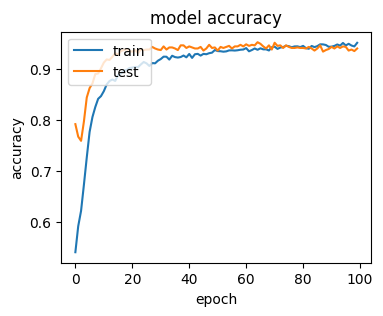

In [107]:
#Testing
score = model.evaluate(test_ds, y_test, batch_size=32)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(his.history.keys())

# summarize history for accuracy
#plt.plot(mo)
fig= plt.figure(figsize=(4,3))
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Export the model

In [108]:
import pathlib
export_dir = 'models/KWS'
model.export(export_dir)

INFO:tensorflow:Assets written to: models/KWS/assets


INFO:tensorflow:Assets written to: models/KWS/assets


Saved artifact at 'models/KWS'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4096), dtype=tf.float32, name='keras_tensor_155')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  130699616528064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130699616528592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130699616518560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130702905098832: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [109]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('models/KWS.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', 'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', 'serving_default', '__saved_model_init_op'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


2024-05-17 01:14:34.408745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:34.408966: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 01:14:34.409044: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-17 01:14:34.409300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:34.409460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-17 01:14:34.525329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:34.525579: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 01:14:34.525677: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-17 01:14:34.525952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

37612

### Post-Quantisation

In [110]:
def representative_dataset_gen(num_samples=100):
    for data in train_ds[:num_samples]:
        yield [data.reshape(1, 128, 32, 1)]
##def representative_data_gen():
##    for input_value, _ in y_test.take(100):
##        yield [input_value]
converter_op = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter_op.optimizations = [tf.lite.Optimize.DEFAULT]
converter_op.representative_dataset = representative_dataset_gen
converter_op.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_op.inference_input_type = tf.int8
converter_op.inference_output_type = tf.int8

tflite_model_file = pathlib.Path('models/KWS_op.tflite')
tflite_model_file.write_bytes(converter_op.convert())

INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


2024-05-17 01:14:36.098605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:36.098885: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 01:14:36.098978: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-17 01:14:36.099304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:36.099478: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serve', '__saved_model_init_op', 'serving_default'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-17 01:14:36.206652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 01:14:36.207134: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 01:14:36.207218: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-17 01:14:36.207481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

12736

In [25]:
import netron
netron.start(R'./models/KWS_op.tflite')

Serving './models/KWS_op.tflite' at http://localhost:8080


('localhost', 8080)

### Create binary file

In [111]:
MODEL_TFLITE = './models/KWS_op.tflite'
MODEL_TFLITE_MICRO = 'kws_yes_no.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [112]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x9c, 0x00, 0x00, 0x00, 0x88, 0x23, 0x00, 0x00,
  0x98, 0x23, 0x00, 0x00, 0x08, 0x31, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x5c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xb8, 0xff, 0xff, 0xff,
  0x15, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00,
  0x43, 0x4f, 0x4e, 0x56, 0x45, 0x52, 0x53, 0x49, 0x4f, 0x4e, 0x5f, 0x4d,
  0x45, 0x54, 0x41, 0x44, 0x41, 0x54, 0x41, 0x00, 0xdc, 0xff, 0xff, 0xff,
  0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00,
  0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f,
  0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x08, 0x

### Evaluation